In [19]:
import pandas as pd

df = pd.read_csv("Fake.csv")
df['label'] = 0

df_real = pd.read_csv("True.csv")
df_real['label'] = 1

data = pd.concat([df, df_real], axis=0)
data = data.sample(frac=1).reset_index(drop=True)
data = data[['text', 'label']]


In [20]:
import re
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r'https?://\S+', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

data['text'] = data['text'].apply(clean_text)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_NUM_WORDS = 20000
MAX_LEN = 300

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(data['text'])

sequences = tokenizer.texts_to_sequences(data['text'])
X = pad_sequences(sequences, maxlen=MAX_LEN)

y = data['label'].values


In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [23]:
from tensorflow.keras.layers import Embedding

vocab_size = min(MAX_NUM_WORDS, len(tokenizer.word_index) + 1)
embedding_dim = 100

embedding_layer = Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    input_length=MAX_LEN,
    trainable=True
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [24]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.layers import GlobalAveragePooling1D, Attention

input_layer = Input(shape=(MAX_LEN,))
x = embedding_layer(input_layer)

x = Bidirectional(LSTM(128, return_sequences=True))(x)

attn = Attention()([x, x])
x = GlobalAveragePooling1D()(attn)

x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 300)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 300, 100)  │  2,000,000 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 300, 256)  │    234,496 │ embedding_2[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_2         │ (None, 300, 256)  │          0 │ bidirectional_2[… │
│ (Attention)         │                   │            │ bidirectional_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 256)       │          0 │ attention_2[0][0] │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 256)       │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64)        │     16,448 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │         65 │ dense_4[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,251,009 (8.59 MB)

 Trainable params: 2,251,009 (8.59 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=5,
    batch_size=64
)

Epoch 1/5
449/449 ━━━━━━━━━━━━━━━━━━━━ 24s 47ms/step - accuracy: 0.8567 - loss: 0.3020 - val_accuracy: 0.9953 - val_loss: 0.0150
Epoch 2/5
449/449 ━━━━━━━━━━━━━━━━━━━━ 41s 47ms/step - accuracy: 0.9967 - loss: 0.0109 - val_accuracy: 0.9958 - val_loss: 0.0147
Epoch 3/5
449/449 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.9992 - loss: 0.0026 - val_accuracy: 0.9958 - val_loss: 0.0190
Epoch 4/5
449/449 ━━━━━━━━━━━━━━━━━━━━ 21s 47ms/step - accuracy: 0.9997 - loss: 0.0013 - val_accuracy: 0.9950 - val_loss: 0.0200
Epoch 5/5
449/449 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 1.0000 - loss: 5.2574e-04 - val_accuracy: 0.9967 - val_loss: 0.0160


In [26]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

y_pred = (model.predict(X_test) > 0.5).astype("int32")

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred))

281/281 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step
[[4675   21]
 [  36 4248]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      4696
           1       1.00      0.99      0.99      4284

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980

ROC-AUC Score: 0.9935623738422115


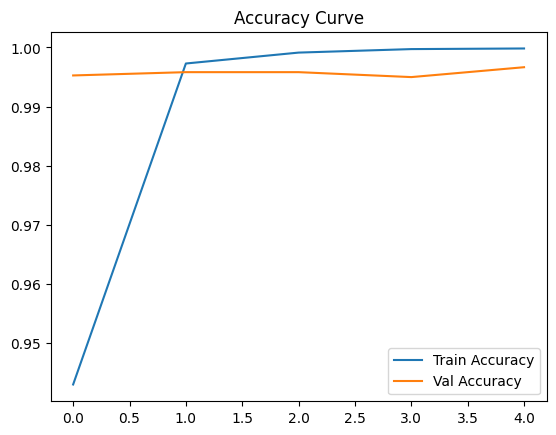

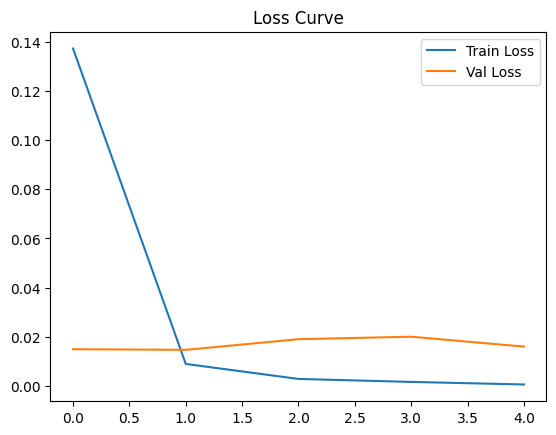

In [27]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title("Accuracy Curve")
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Curve")
plt.show()
